In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation

from src.objects import Rectangle, Circle

# Simulate in Rectangle

In [2]:
# Initialize rectangle scene
width = 10
height = 10
rectangle_scene = Rectangle(width, height)

# Generate particles
num_particles = 150
radius_range = (0.2, 0.2)
density_range = (1, 1)

# Add particles to the rectangle scene
rectangle_scene.generate_particles(num_particles=num_particles, radius_range=radius_range, density_range=density_range)

In [ ]:

# Simulation parameters
n_steps = 1000
dt = 0.0001

for _ in range(n_steps):
    rectangle_scene.simulate(1, dt)

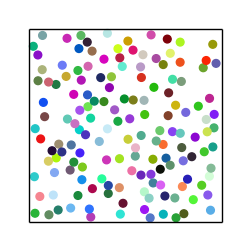

In [3]:
# New parameter to control frame skipping
skip_frames = 6  # Change this value to skip frames (e.g., 2 to skip every other frame). Makes animation speed up

# Prepare the figure and axes for plotting
fig, ax = plt.subplots(1, 1, figsize=(3, 3))
factor = 0.1
ax.set_xlim(0 - factor * width, width + factor * width)
ax.set_ylim(0 - factor * height, height + factor * height)

# Draw rectangle (walls)
wall_width = 1
ax.hlines(y=height, xmin=0, xmax=width, ls='-', lw=wall_width, color='black')
ax.hlines(y=0, xmin=0, xmax=width, ls='-', lw=wall_width, color='black')
ax.vlines(x=0, ymin=0, ymax=height, ls='-', lw=wall_width, color='black')
ax.vlines(x=width, ymin=0, ymax=height, ls='-', lw=wall_width, color='black')

# Create Circle patches for the particles
circles = []
for particle in rectangle_scene.particles:
    circle = plt.Circle(particle.position, particle.radius, color=particle.color, fill=True)
    ax.add_patch(circle)
    circles.append(circle)

ax.set_xticks([])
ax.set_yticks([])
ax.set_aspect('equal', 'box')
plt.axis('off')

# Update function for the animation
def update(frame):
    # Adjust frame based on skip_frames
    frame = frame * skip_frames

    # For each particle, get the position from its path_history at the adjusted frame
    for i, particle in enumerate(rectangle_scene.particles):
        if frame < len(particle.path_history):  # Ensure the frame doesn't exceed path_history length
            circles[i].center = particle.path_history[frame]  # Update position from path_history

    return circles

# Adjust the number of frames based on the skip_frames parameter
adjusted_n_steps = n_steps // skip_frames

# Create the animation
ani = FuncAnimation(fig, update, frames=adjusted_n_steps, interval=30, blit=True)

# Save animation to file (optional)
ani.save(filename="rectangle_particle_simulation.gif", writer='pillow')

# Simulate in Circle

In [4]:
# Initialize circle scene
scene_radius = 5
circle_scene = Circle(scene_radius)

# Generate particles
num_particles = 150
radius_range = (0.2, 0.2)
density_range = (1, 1)

# Add particles to the circle scene
circle_scene.generate_particles(num_particles=num_particles, radius_range=radius_range, density_range=density_range)

# Simulation parameters
n_steps = 1000
dt = 0.0001

In [5]:
# Simulate the scene
for _ in range(n_steps):
    circle_scene.simulate(1, dt)

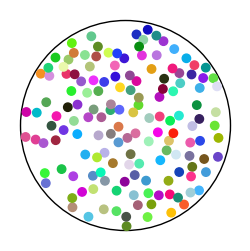

In [6]:
# New parameter to control frame skipping
skip_frames = 6  # Change this value to skip frames (e.g., 2 to skip every other frame). Makes animation speed up

# Prepare the figure and axes for plotting
fig, ax = plt.subplots(1, 1, figsize=(3,3))
factor = 0.1
ax.set_xlim(-scene_radius - factor * scene_radius, scene_radius + factor * scene_radius)
ax.set_ylim(-scene_radius - factor * scene_radius, scene_radius + factor * scene_radius)

# Draw circle (wall)
wall_width = 1
main_circle = plt.Circle((0,0), scene_radius, color='black', fill=False, lw=wall_width)
ax.add_patch(main_circle)

# Create Circle patches for the particles
circles = []
for particle in circle_scene.particles:
    circle = plt.Circle(particle.position, particle.radius, color=particle.color, fill=True)
    ax.add_patch(circle)
    circles.append(circle)

ax.set_xticks([])
ax.set_yticks([])
ax.set_aspect('equal', 'box')
plt.axis('off')

# Update function for the animation
def update(frame):
    # Adjust frame based on skip_frames
    frame = frame * skip_frames

    # For each particle, get the position from its path_history at the adjusted frame
    for i, particle in enumerate(circle_scene.particles):
        if frame < len(particle.path_history):  # Ensure the frame doesn't exceed path_history length
            circles[i].center = particle.path_history[frame]  # Update position from path_history

    return circles

# Adjust the number of frames based on the skip_frames parameter
adjusted_n_steps = n_steps // skip_frames

# Create the animation
ani = FuncAnimation(fig, update, frames=adjusted_n_steps, interval=30, blit=True)

# Save animation to file (optional)
ani.save(filename="circle_particle_simulation.gif", writer='pillow')